# COMP 551 — Assignment 3

Authors:
 - Bernier, Audréanne
 - Coull-Neveu, Ben
 - Trachsel-Bourbeau, Anjara

Imports

In [1]:
from torchvision import datasets, transforms
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

CHECKLIST
- Implementation of data normalization (1 points)
- Implementation and training of MLP with no hidden layers (1 points)
- Implementation and training of MLP with one hidden layers and ReLU activation (3 points)
- Implementation and training of MLP with two hidden layers and ReLU activation (1 points)
- Implementation and training of the two hidden layers MLP with tanh activation (2 points)
- Implementation and training of the two hidden layers MLP with Leaky-ReLU activation (2 points)
- L1 regularization (2 points)
- L2 regularization (2 points)
- Train MLP without normalization (1 points)
- Correctly plot and compare the results of the 8 trained models above (5 points)
- Train the MLP with the 128 x 128 FashionMNIST data (1 points)
- Plot the results of the larger models, and compare classification performance and training time (2 points)
- Implement and train the CNN (2 points)
- Re-train the CNN with the 128 x 128 FashionMNIST data (1 points)
- Plot the results of the two CNN trained, and compare classification performance and training time to the best MLP. (4 points)
- Implement and train the pre-trained model with the trainable fully connected layer(s). (3 points)
- Plot the results of the pre-trained model, and compare its performance to the best MLP and regular CNN.(4 points)
- Run an experiment to justify the choice of fully connected layers for the pre-trained model, and show
supporting plots. (3 points)

You can report your findings either in the form of a table or a plot in the write-up. However, include in your
colab notebooks the plots of the test and train performance of the MLPs / CNN / pre-trained model as a function
of training epochs. This will allow you to see how much the network should be trained before it starts to overfit
to the training data.

Note 2: We expect you to provide plots/tables in your report that justifies your choice of hyperparameters
(the learning rates of the MLPs / CNNs / pretrained models, the architectural parameters of the CNNs and
pretrained models). You are not required to perform cross-validation in this project.

## Other functions

In [2]:
#CE loss
def cross_entropy_loss(y_true, y_pred):
    N = y_true.shape[0]
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    # Compute cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred)) / N
    return loss


# accuracy
def accuracy(y_true, y_pred):
    correct_predictions = np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1)
    accuracy = np.mean(correct_predictions)
    return accuracy

# Implement MLP

In [280]:
# Activation functions and their derivatives
def softmax(z):
    z = np.atleast_2d(z)  # make sure z is 2D
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / e_z.sum(axis=1, keepdims=True)
# softmax = lambda z: np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

def relu(z, deriv=False):
    if deriv:
        return np.where(z > 0, 1, 0)
    return np.maximum(0, z)

def tanh(z, deriv=False):
    if deriv:
        return 1 - np.tanh(z)**2
    return np.tanh(z)

def leaky_relu(z, l=0.01, deriv=False):
    if deriv:
        return np.where(z > 0, 1, l)
    return np.maximum(0, z) + l * np.minimum(0, z)

In [332]:
# Gradient function
def gradient(x, # N x D
             y, # N x C
             params, # Replaces explicit params below
            #  w, # M2 x C 
            #  v1 = None, # D x M1
            #  v2=None, # M1 x M2
             h = None,  # hidden layer activations (for L=2)
             L=0
             ):
    # output layer (CE loss and softmax activation)
    N,D = x.shape

    # -- 0 hidden layers --
    # yh = softmax(WX)
    if L==0:
        w, b = params
        yh = softmax(np.dot(x, w) + b)  # N x C

        # compute dW = (yh - y)x /N
        dy = yh - y  # N x C
        dw = np.dot(x.T, dy)/N  # D x C
        db = np.mean(dy, axis=0) # C

        return dw, db

    # -- 1 hidden layer --
    # yh = softmax(W h(V1X)) with h = ReLU
    elif L==1:
        try:
            v1, c1, w, b = params
        except ValueError:
            raise ValueError("Expected 4 parameters for L=1: v1, c1, w, b")
        # assert v1 is not None, "v1 must be provided for L=1"
        
        # forward pass
        q = np.dot(x, v1) + c1  # N x M1
        z = h(q)  # N x M1 (general activation!)
        yh = softmax(np.dot(z, w) + b)  # N x C

        # compute dW = (yh - y)z /N
        dy = yh - y  # N x C
        dw = np.dot(z.T, dy)/N  # M1 x C

        # compute dV1 = (yh-y)W dq x /N where dq = ReLU derivative
        dq = h(q, deriv=True)  # N x M1 (derivative of of activation function)
        dz = np.dot(dy, w.T)  # N x M1
        dv = np.dot(x.T, dz * dq)/N  # D x M1
        dc = np.mean(dz * dq, axis=0)
        db = np.mean(dy, axis=0)
        
        return dv, dc, dw, db

    # -- 2 hidden layers --
    # yh = softmax(W h(V2 g(V1 X))) with g = h = {ReLU, tanh, or leaky ReLU}
    elif L==2:
        try:
            v1, c1, v2, c2, w, b = params
        except ValueError:
            raise ValueError("Expected 6 parameters for L=2: v1, c1, v2, c2, w, b")
        # assert v1 is not None and v2 is not None and h is not None, "v1, v2, and h must be provided for L=2"
        
        # forward pass
        q1 = np.dot(x, v1) + c1  # N x M1
        z1 = h(q1)  # N x M1
        q2 = np.dot(z1, v2) + c2  # N x M2
        z2 = h(q2)  # N x M2
        yh = softmax(np.dot(z2, w) + b)  # N x C

        # compute dW = (yh - y)z2 /N
        dy = yh - y  # N x C
        dw = np.dot(z2.T, dy)/N  # M2 x C

        # compute dV2 = (yh - y)W dq2 z1 /N where dq2 depends on h
        dq2 = h(q2, deriv=True) # dh/dq2, depends on activation function
        dz2 = np.dot(dy, w.T)  # N x M2
        dv2 = np.dot(z1.T, dz2 * dq2)/N  # M1 x M2

        # compute dV1 = (yh - y)W dq2 V2 dq1 x /N  where dq1 depends on h
        dq1 = h(q1, deriv=True)  # dh/dq1, depends on activation function
        dz1 = np.dot(dz2 * dq2, v2.T)  # N x M1
        dv1 = np.dot(x.T, dz1 * dq1)/N  # D x M1
        db = np.mean(dy, axis=0)
        dc2 = np.mean(dz2 * dq2, axis=0)
        dc1 = np.mean(dz1 * dq1, axis=0)
        
        return dv1, dc1, dv2, dc2, dw, db

In [282]:
class MLP:
    """
    Supports L = 0,1,2 hidden layers.

    Constructor takes:
    h = hidden activation function (same for all hidden layers)
    L = number of hidden layers
    M = number of hidden units, iterable (each element corresponds to a layer)
    
    -> Weights and biases are initialized randomly
    """

    def __init__(self, h=None, L=1, M=64, D=None, C=10): 
        self.h = h if h is not None else lambda x: x # default identity
        self.L = L
        
        if isinstance(M, int):
            self.M = [M] * L  # same num of units in each layer
        else:
            assert len(M) == L, "Length of M must equal L"
            self.M = M
        
        # Initialize weights & biases depending on # of layers (L)
        assert D is not None, "Need number of features"
        if L == 0:  # no hidden layer
            self.w = np.random.randn(D, C) * 0.1
            self.b = np.zeros(C)
        elif L == 1:  # 1 hidden layer
            self.v = np.random.randn(D, self.M[0]) * 0.1  # 1st hidden layer, D x M
            self.c = np.zeros(self.M[0])
            self.w = np.random.randn(self.M[0], C) * 0.1  # output layer, M x C
            self.b = np.zeros(C)
        elif L == 2:  # 2 hidden layers
            self.v1 = np.random.randn(D, self.M[0]) * 0.1  # 1st hidden layer, D x M1
            self.c1 = np.zeros(self.M[0])
            self.v2 = np.random.randn(self.M[0], self.M[1]) * 0.1  # 2nd hidden layer, M1 x M2
            self.c2 = np.zeros(self.M[1])
            self.w = np.random.randn(self.M[1], C) * 0.1  # output layer, M2 x C
            self.b = np.zeros(C)


    def fit(self, x, y, optimizer):
        # Put current weights into a list (for gradient function)
        if self.L == 0:
            params0 = [self.w, self.b]
        elif self.L == 1:
            params0 = [self.v, self.c, self.w, self.b,]
        elif self.L == 2:
            params0 = [self.v1, self.c1, self.v2, self.c2, self.w, self.b]
        
        # Define gradient function for optimizer
        gradient_fn = lambda x, y, p: gradient(x, y, p, h=self.h, L=self.L)  

        # Run optimizer
        self.params = optimizer.run(gradient_fn, x=x, y=y, params=params0)
        return self
    

    def predict(self, x):
        if self.L == 0:
            w, b = self.params
            yh = softmax(np.dot(x, w) + b)  # N x C
        elif self.L == 1:
            v, c, w, b = self.params
            q = np.dot(x, v) + c  # N x M
            z = self.h(q)  # N x M
            yh = softmax(np.dot(z, w) + b)  # N x C
        elif self.L == 2:
            v1, c1, v2, c2, w, b = self.params
            q1 = np.dot(x, v1) + c1  # N x M1
            z1 = self.h(q1)  # N x M1
            q2 = np.dot(z1, v2) + c2  # N x M2
            z2 = self.h(q2)  # N x M2
            yh = softmax(np.dot(z2, w) + b)  # N x C
        return yh

In [283]:
# Gradient Descent Optimizer
class GradientDescent:
    
    def __init__(self, learning_rate=.001, epsilon=1e-8, max_iters=1, record_grad=False):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.record_grad = record_grad
        self.history_grad = []
        
    def run(self, gradient_fn, x, y, params):
        """
        This does GD for x and y (which are already a SINGLE BATCH of the data)

        gradient_fn: function that computes gradients
        params: list of weight matrices, e.g., [v1, c1, v2, c2, w, b]
        """
        
        norms = np.array([np.inf])
        t=0

        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            
            norms = np.array([np.linalg.norm(g) for g in grad])
            # record gradients if desired
            if self.record_grad:
                total_norm = np.sqrt(np.sum(norms**2))
                self.history_grad.append(total_norm)
            
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
    
        return params

# Load Data

"In the context of images, normalization means converting pixel values (originally in the range [0, 255]) to a specific range, usually between 0 and 1 or -1 and 1, usually by first scaling to [0, 1] (i.e., dividing by 255), and then subtracting the mean and dividing by the standard deviation, either per-channel (for color images) or over the entire training set (for grayscale). This helps stabilize training by centering the data and ensuring all features (pixels) contribute proportionally during optimization."

In [7]:
# Compute mean and std from train dataset (for normalization)
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
data = dataset.data.float() / 255.0  # convert to float and scale to [0,1]

# Compute mean and std over all training set (since greyscale images)
mean = data.mean()
std = data.std()
print(mean, std)

tensor(0.2860) tensor(0.3530)


In [8]:
# Load the FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), # scales to [0,1]
                                transforms.Normalize((mean,), (std,))  # mean 0, std 1
                                ])

train_dataset = datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
    )
test_dataset = datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
    )

# Look at full dataset info
print(train_dataset.classes)
print(train_dataset.data.shape)
print(train_dataset.targets.shape)

print(test_dataset.classes)
print(test_dataset.data.shape)
print(test_dataset.targets.shape)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
torch.Size([60000, 28, 28])
torch.Size([60000])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
torch.Size([10000, 28, 28])
torch.Size([10000])


In [9]:
BATCH_SIZE = 512

# Get loaders (makes batches for later)
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
    )
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

# looking at data in 1 batch
images0, labels0 = next(iter(train_loader))  # get first batch
print(images0.shape)  # (batch_size, 1, 28, 28)
print(labels0.shape)  # (batch_size,)
# same for test loader

torch.Size([512, 1, 28, 28])
torch.Size([512])


# MLP Experiments

In [10]:
# TUNING THE HYPERPARAMETERS --> KEP THEM THE SAME FOR ALL TRAINING?
# SEE ED

## 1 - Vary number of hidden layers

First of all, create three different models: (1) an MLP with no hidden layers, i.e., it directly maps the inputs
to outputs, (2) an MLP with a single hidden layer having 256 units and ReLU activations, (3) an MLP with 2
hidden layers each having 256 units with ReLU activations. It should be noted that since we want to perform
classification, all of these models should have a softmax layer at the end. After training, compare the test
accuracy of these three models on the FashionMNIST dataset. Comment on how non-linearity and network
depth affects the accuracy. Are the results that you obtain expected?

In [16]:
# --- 0 Hidden Layers ---
# Define MLP and optimizer
model0 = MLP(
    L = 0, 
    D=28*28
    )
optimizer = GradientDescent(learning_rate=.01, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 50
num_classes = 10

# Loop over epochs
grad = {}
loss = {}
for epoch in range(num_epochs):
    grad[epoch] = []
    loss[epoch] = []
    # Go through batches
    batch_num = len(train_loader)
    current_loss = np.inf
    for i, (b_x, b_y) in enumerate(train_loader):
        # flatten images
        b_x = b_x.view(b_x.size(0), -1).numpy()
        # one-hot encode labels
        y_batch = np.eye(num_classes)[b_y.numpy()]
        # fit model on this batch
        model0.fit(b_x, y_batch, optimizer)
        grad[epoch].append(optimizer.history_grad[-1])
        # compute loss on this batch
        yhat_batch = model0.predict(b_x)
        batch_loss = cross_entropy_loss(y_batch, yhat_batch)
        loss[epoch].append(batch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{batch_num} === Loss: {batch_loss:.3} {' '*10}", end='\r')

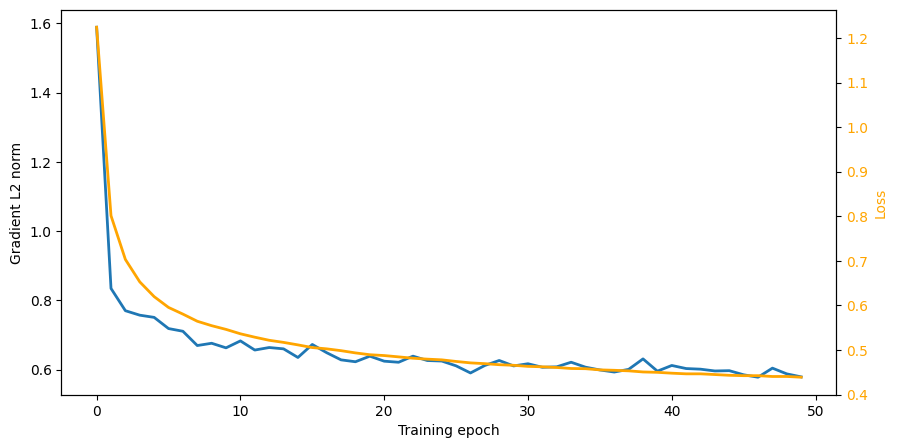

In [18]:
# optionally smooth the curve
def smooth(x, w=30):
    return np.convolve(x, np.ones(w)/w, mode='valid')

# plot average gradient norm per epoch
grad_avg = [np.mean(grad[epoch]) for epoch in range(num_epochs)]
loss_avg = [np.mean(loss[epoch]) for epoch in range(num_epochs)]

plt.figure(figsize=(10,5))
plt.plot(grad_avg, alpha=1, label="raw", lw=2)
# plt.plot(smooth(grad_avg, w=5), linewidth=3, label="smoothed")
plt.xlabel("Training epoch")
plt.ylabel("Gradient L2 norm")
# plt.legend()

ax_twin = plt.gca().twinx()
ax_twin.plot(loss_avg, color='orange', alpha=1, lw=2)
ax_twin.set_ylabel("Loss", color='orange')
ax_twin.tick_params(axis='y', labelcolor='orange')


plt.show()


Accuracy on test set: 0.8515625


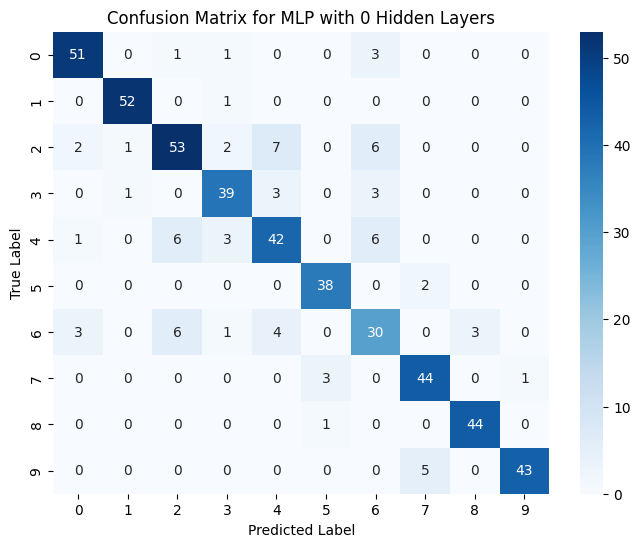

In [23]:
# Checking test predictions for first batch
test_images, test_labels = next(iter(test_loader))
test_images = test_images.view(test_images.size(0), -1).numpy()
test_labels_onehot = np.eye(num_classes)[test_labels.numpy()]

yhat = model0.predict(test_images)  # N x C


# print("Truth:\n", np.array(test_labels), "\nPrediction:\n", np.argmax(yhat, axis=1))
print("Accuracy on test set:", accuracy(test_labels_onehot, yhat))

# create confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(test_labels.numpy(), np.argmax(yhat, axis=1)):
    confusion_matrix[true_label, pred_label] += 1
# visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP with 0 Hidden Layers')
plt.show()

Predictions: [1 0 1 0]
True labels: [0 1 1 0]


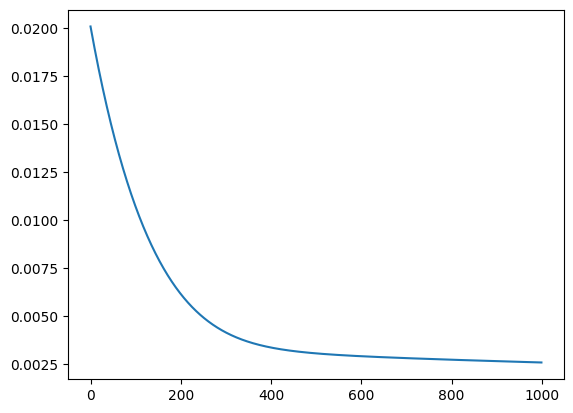

In [355]:
# TESTING... should work with a 1 layer MLP?
import numpy as np

# --- Toy dataset ---
# 4 samples, 2 features
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

# Binary labels (0 or 1)
y = np.array([0, 1, 1, 0])  # e.g., XOR-ish pattern

# One-hot encode labels
C = 2
Y = np.eye(C)[y]  # shape (4, 2)



# --- Define simple MLP with 0 hidden layers ---
model = MLP(L=1, M=16, D=2, C=2, h=tanh)
# optimizer = GradientDescent(learning_rate=0.1, max_iters=100)  # small toy example
optimizer = GradientDescent(learning_rate=0.01, epsilon=1e-4, max_iters=1000, record_grad=True)
model.fit(X, Y, optimizer)  # fit on all data at once
yhat = model.predict(X)
print("Predictions:", np.argmax(yhat, axis=1))
print("True labels:", y)

plt.plot(optimizer.history_grad)

In [213]:
# --- 1 Hidden Layer ---
model1 = MLP(h=relu, L=1, M=256, D=28*28)

optimizer = GradientDescent(learning_rate=.01, record_grad=True)  # doing one GD iteration by batch in one epoch
num_epochs = 50
num_classes = 10

# Loop over epochs
grad1 = {}
loss1 = {}
for epoch in range(num_epochs):
    grad1[epoch] = []
    loss1[epoch] = []
    # Go through batches
    batch_num = len(train_loader)
    for i, (b_x, b_y) in enumerate(train_loader):
        # flatten images
        b_x = b_x.view(b_x.size(0), -1).numpy()
        # one-hot encode labels
        y_batch = np.eye(num_classes)[b_y.numpy()]
        # fit model on this batch
        model1.fit(b_x, y_batch, optimizer)
        grad1[epoch].append(optimizer.history_grad[-1])
        # compute loss on this batch
        yhat_batch = model1.predict(b_x)
        batch_loss1 = cross_entropy_loss(y_batch, yhat_batch)
        loss1[epoch].append(batch_loss1)
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{batch_num} === Loss: {batch_loss1:.3} {' '*10}", end='\r')

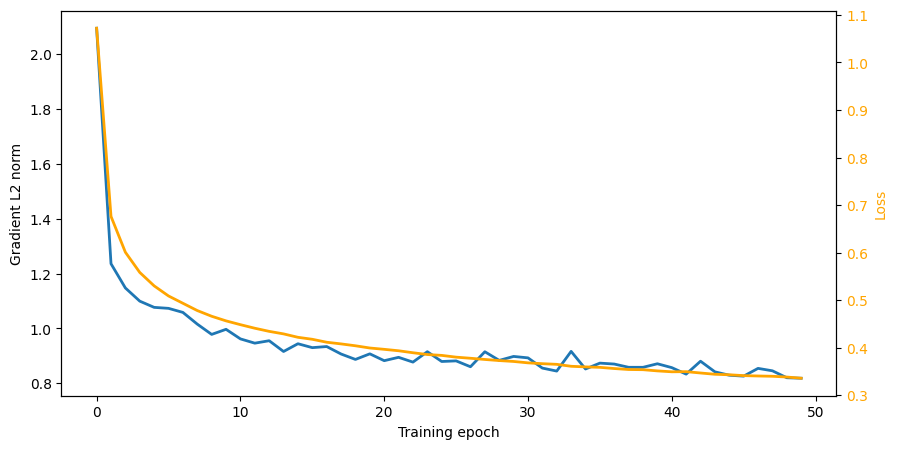

In [216]:
# plot average gradient norm per epoch
grad_avg = [np.mean(grad1[epoch]) for epoch in range(num_epochs)]
loss_avg = [np.mean(loss1[epoch]) for epoch in range(num_epochs)]

plt.figure(figsize=(10,5))
plt.plot(grad_avg, alpha=1, label="raw", lw=2)
# plt.plot(smooth(grad_avg, w=5), linewidth=3, label="smoothed")
plt.xlabel("Training epoch")
plt.ylabel("Gradient L2 norm")
# plt.legend()

ax_twin = plt.gca().twinx()
ax_twin.plot(loss_avg, color='orange', alpha=1, lw=2)
ax_twin.set_ylabel("Loss", color='orange')
ax_twin.tick_params(axis='y', labelcolor='orange')


plt.show()


Accuracy on test set: 0.865234375


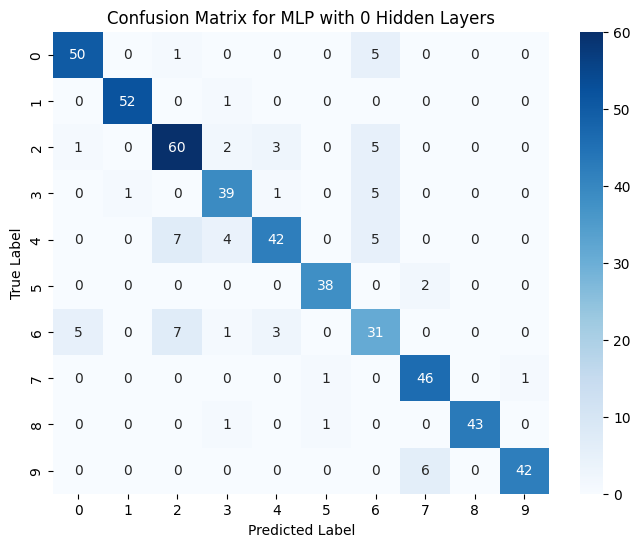

In [217]:
# Checking test predictions for first batch
test_images, test_labels = next(iter(test_loader))
test_images = test_images.view(test_images.size(0), -1).numpy()
test_labels_onehot = np.eye(num_classes)[test_labels.numpy()]

yhat = model1.predict(test_images)  # N x C


# print("Truth:\n", np.array(test_labels), "\nPrediction:\n", np.argmax(yhat, axis=1))
print("Accuracy on test set:", accuracy(test_labels_onehot, yhat))

# create confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(test_labels.numpy(), np.argmax(yhat, axis=1)):
    confusion_matrix[true_label, pred_label] += 1
# visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP with 0 Hidden Layers')
plt.show()

In [80]:
# --- 2 Hidden Layers ---
model2 = MLP(h=relu, L=2, M=256, D=28*28)

## 2 - Changing activations in 2-layer MLP

Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the
activations are now tanh and Leaky-ReLU. After training these two models compare their test accuracies with
model having ReLU activations. Comment on the performances of these models: which one is better and why?
Are certain activations better than others? If the results are not as you expected, what could be the reason?

## 3 - Adding regularization to 2-layer MLP

Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this
time, independently add L1 and L2 regularization to the network and train the MLP in this way. How does
these regularizations affect the accuracy? This proportion can be varied as a tunable hyperparameter that can be
explored as part of other project requirements.

## 4 - Unnormalized 2-layer MLP

Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this time,
train it with unnormalized images. How does this affect the accuracy?

## 5 - Data augmentation

Re-train the MLP from question 3 on a version of FashionMNIST using data augmentation. You can use the
transforms.Compose() function to set your transformations for data augmentation, and the
transform=train transform argument in the dataset constructor to set the transforms. Is the accuracy
affected, and how? What are the benefits and/or drawbacks of using data augmentation? Can you think of a
situation in which certain types data augmentation would be harmful?

In [ ]:
# reload the data and add other transformations

# CNN Experiments

## 6 - Create a CNN

Using existing libraries such as TensorFlow or PyTorch, create a convolutional neural network (CNN) with 2
convolutional layers, one fully connected hidden layer and one fully connected output layer. Although you
are free in your choice of the hyperparameters of the convolutional layers, set the number of units in the fully
connected layers to be 256. Also, set the activations in all of the layers to be ReLU. Train this CNN on the
FashionMNIST dataset. Does using a CNN increase/decrease the accuracy compared to using MLPs? Provide
comments on your results.

## 7 - Data augmentation

Train the above CNN using FashionMNIST with the data augmentation from Q5. How is the performance
(accuracy and speed) affected?

## 8 - Pre-trained model

Load a pre-trained model that you see fit (e.g., a ResNet) using existing libraries such as TensorFlow or PyTorch,
and then freeze all the convolutional layers and remove all the fully connected ones. Add a number of fully
connected layers of your choice right after the convolutional layers. Train only the fully connected layers of the
pre-trained model on the FashionMNIST dataset with the data augmentation from Q5. How does this pre-trained
model compare to the best MLP in part 5 and to the CNN in part 7 in terms of accuracy? How does it compare
to the previous models in terms of the required training time? Justify your choice of how many fully connected
layers that you have added to the pre-trained model through careful experiments.

# TO CLEAN:

In [ ]:
# TODO: find better way to normalize dataset *****FIXED? SEE LOADING DATA SECTION

def compute_loader_stats(loader, return_distribution=False):
    n_pixels = 0
    sum_pixels = 0
    sum_squared = 0
    
    dist = []
    for images, _ in loader:
        n_pixels += images.numel()
        sum_pixels += images.sum().item()
        sum_squared += (images ** 2).sum().item()
        if return_distribution:
            dist.append(images.numpy().flatten())
        
    mean = sum_pixels / n_pixels
    var = (sum_squared / n_pixels) - (mean ** 2)
    std = np.sqrt(var)
    return mean, std, dist if return_distribution else (mean, std)


def compute_data_stats(*loaders, return_distribution=False):
    total_mean = 0
    total_std = 0
    for loader in loaders:
        stats = compute_loader_stats(loader, return_distribution=return_distribution)
        total_mean += stats[0]
        total_std += stats[1]
        print(f'Loader mean: {stats[0]:.4f}, std: {stats[1]:.4f}')
    n_loaders = len(loaders)
    print(f'Overall mean: {total_mean / n_loaders:.4f}, std: {total_std / n_loaders:.4f}')
    total_mean /= n_loaders
    total_std /= n_loaders
    return total_mean, total_std, stats[2] if return_distribution else (total_mean, total_std)

In [61]:
# temp variables until normalization done
norm_train = train_dataset
norm_test = test_dataset

In [ ]:
# stats = compute_data_stats(train_loader, test_loader, return_distribution=True)
# mean, std = stats[0], stats[1]
# print(f'Final mean: {mean:.4f}, std: {std:.4f}')

# distribution_prenorm = np.concatenate(stats[2])

In [56]:
# sns.histplot(distribution_prenorm, bins=100, kde=True)
# plt.yscale('log')
# plt.title('Pixel Value Distribution Before Normalization')

In [55]:
# # normalize datasets
# train_dataset.transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((mean,), (std,))
# ])

# test_dataset.transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((mean,), (std,))
# ])

In [62]:
# stats = compute_data_stats(train_loader, test_loader, return_distribution=True)
# mean_postnorm, std_postnorm = stats[0], stats[1]
# print(f'Final mean: {mean_postnorm:.4f}, std: {std_postnorm:.4f}')

# distribution_postnorm = np.concatenate(stats[2])

In [58]:
# sns.histplot(distribution_postnorm, bins=100, kde=True)
# plt.yscale('log')
# plt.title('Pixel Value Distribution Before Normalization')